# Метод сопряженных градиентов

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(228)

# Parameters
n = 100  # Dimension of x
mu = 10
L = 100


def generate_problem(n=100, mu=mu, L=L, problem_type="clustered"):
    np.random.seed(228)
    if problem_type == "clustered":
        

    elif problem_type == "random":
        A = np.random.randn(n, n)
        factual_L = max(np.linalg.eigvalsh(A.T@A))
        A = A.T.dot(A)/factual_L*L + mu*np.eye(n)
        x_opt = np.random.rand(n)
        b = A@x_opt
        x_0 = 3*np.random.randn(n)
    
    elif problem_type == "uniform spectrum":
        A = np.diag(np.linspace(mu, L, n, endpoint=True))
        x_opt = np.random.rand(n)
        b = A@x_opt
        x_0 = 3*np.random.randn(n)

    elif problem_type == "Hilbert":
        A = np.array([[1.0 / (i+j - 1) for i in range(1, n+1)] for j in range(1, n+1)])
        b = np.ones(n)
        x_0 = 3*np.random.randn(n)
        x_opt = np.linalg.lstsq(A, b)[0]

    elif problem_type == "worst_cg":
        # Parameter t controls the condition number
        t = 0.6  # Small t leads to worse conditioning
        # Create tridiagonal matrix W
        main_diag = np.ones(n)
        main_diag[0] = t
        main_diag[1:] = 1 + t
        off_diag = np.sqrt(t) * np.ones(n-1)
        A = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
        
        # Create b vector [1, 0, ..., 0]
        b = np.zeros(n)
        b[0] = 1
        
        # Since this is a specific problem, we compute x_opt explicitly
        x_opt = np.linalg.solve(A, b)
        x_0 = np.zeros(n)  # Start from zero vector
        return A, b, x_0, x_opt

    return A, b, x_0, x_opt

# Optimization methods
def gradient_descent(f, grad_f, x_0, step_size, iterations, x_opt):
    x = x_0.copy()
    f_opt = f(x_opt)
    values, gradients = [], []
    values.append(abs(f(x) - f_opt))
    gradients.append(np.linalg.norm(grad_f(x)))
    for _ in range(iterations):
        x -= step_size * grad_f(x)
        values.append(abs(f(x) - f_opt))
        gradients.append(np.linalg.norm(grad_f(x)))
    return values, gradients

def steepest_descent(A, f, grad_f, x_0, iterations, x_opt):
    x = x_0.copy()
    f_opt = f(x_opt)
    values, gradients = [], []
    values.append(abs(f(x) - f_opt))
    gradients.append(np.linalg.norm(grad_f(x)))
    for _ in range(iterations):
        grad = grad_f(x)
        step_size = np.dot(grad.T, grad) / np.dot(grad.T, np.dot(A, grad))
        x -= step_size * grad
        values.append(abs(f(x) - f_opt))
        gradients.append(np.linalg.norm(grad))
    return values, gradients

def nesterov_accelerated_gradient(A, b, x_0, alpha, beta, iterations, x_opt):
    x = x_0.copy()
    y = x.copy()
    f_opt = f(x_opt)
    prev_x = x.copy()
    values, gradients = [f(x)], [np.linalg.norm(np.dot(A, x) - b)]
    for _ in range(iterations):
        y = (1-beta)*y + beta * x
        grad = grad_f(y)
        x, y = y - alpha * grad, y
        
        values.append(abs(f(x) - f_opt))
        gradients.append(np.linalg.norm(grad))
    return values, gradients

def conjugate_gradient(A, b, x_0, iterations, x_opt):
    x = x_0.copy()
    f = lambda x: 0.5 * x.T @ A @ x - b.T @ x
    f_opt = f(x_opt)
    r = b - np.dot(A, x)
    p = r.copy()
    values, gradients = [f(x)], [np.linalg.norm(r)]
    for _ in range(iterations-1):
        alpha = np.dot(r.T, r) / np.dot(p.T, np.dot(A, p))
        x += alpha * p
        r_next = r - alpha * np.dot(A, p)
        beta = np.dot(r_next.T, r_next) / np.dot(r.T, r)
        p = r_next + beta * p
        r = r_next
        values.append(abs(f(x) - f_opt))
        gradients.append(np.linalg.norm(r))
    return values, gradients


def run_experiment(params):
    A, b, x_0, x_opt = generate_problem(n=params["n"], mu=params["mu"], L=params["L"], problem_type=params["problem_type"])
    eigs = np.linalg.eigvalsh(A)
    mu, L = min(eigs), max(eigs)

    f = lambda x: 0.5 * x.T @ A @ x - b.T @ x
    grad_f = lambda x: A@x - b

    if mu <= 1e-2:
        alpha = 1/L
    else:
        alpha = 2/(mu+L)  # Step size
    beta = (np.sqrt(L) - np.sqrt(mu))/(np.sqrt(L) + np.sqrt(mu))  # Momentum parameter

    results = {
        "methods": {
            "Gradient Descent": gradient_descent(f, grad_f, x_0, alpha, params["iterations"], x_opt),
            "Steepest Descent": steepest_descent(A, f, grad_f, x_0, params["iterations"], x_opt),
            "Conjugate Gradients": conjugate_gradient(A, b, x_0, params["iterations"], x_opt),
            # "nag": nesterov_accelerated_gradient(A, b, x_0, alpha, beta, params["iterations"], x_opt),
        },
        "problem":{
            "eigs": eigs,
            "params": params
        }
    }
    return results


def plot_results(results):
    linestyles = {
        "Gradient Descent": "r-",
        "Steepest Descent": "b-.",
        "Conjugate Gradients": "g--"
    }
    plt.figure(figsize=(10, 3.5))
    mu = results["problem"]["params"]["mu"]
    L = results["problem"]["params"]["L"]
    n = results["problem"]["params"]["n"]
    problem_type = results["problem"]["params"]["problem_type"]
    
    if mu > 1e-2:
        plt.suptitle(f"Strongly convex quadratics. n={n}, {problem_type} matrix. ")
    else:
        plt.suptitle(f"Convex quadratics. n={n}, {problem_type} matrix. ")

    plt.subplot(1, 3, 1)
    eigs = results["problem"]["eigs"]
    plt.scatter(np.arange(len(eigs)), eigs)
    plt.xlabel('Dimension')
    plt.ylabel('Eigenvalues of A')
    plt.grid(linestyle=":")
    plt.title("Eigenvalues")
    if results["problem"]["params"]["problem_type"] == "Hilbert":
        plt.yscale("log")

    plt.subplot(1, 3, 2)
    for method, result_  in results["methods"].items():
        plt.semilogy(result_[0], linestyles[method])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.grid(linestyle=":")
    plt.title("Function gap")

    plt.subplot(1, 3, 3)
    for method, result_ in results["methods"].items():
        plt.semilogy(result_[1], linestyles[method], label=method)
    plt.ylabel(r'$\|\nabla f(x)\|_2$')
    plt.grid(linestyle=":")
    plt.title("Norm of Gradient")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"cg_{problem_type}_{mu}_{L}_{n}.pdf")
    plt.show()

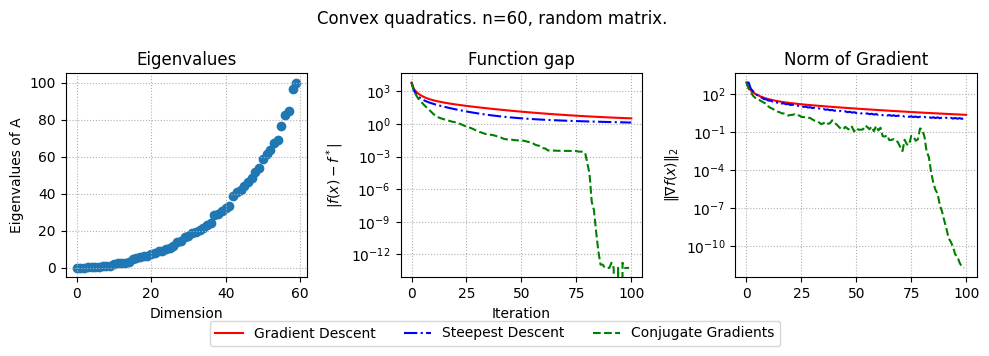

In [2]:
# Experiment parameters
params = {
    "n": 60,
    "mu": 1e-3,
    "L": 100,
    "iterations": 100,
    "problem_type": "random",  # Change to "clustered", "uniform spectrum", or "Hilbert" as needed
}

results = run_experiment(params)
plot_results(results)

## Упражнение 1

В коде выше добавьте генерацию матрицы положительно определенной $A$, кластер которой состоит из 4 различных значений.


In [ ]:
# Experiment parameters
params = {
    "n": 60,
    "mu": 1e-3,
    "L": 100,
    "iterations": 100,
    "problem_type": "random",  # Change to "clustered"
}

results = run_experiment(params)
plot_results(results)

# Предобуславливатели

## Упражнение 2

В коде ниже добавьте функцию, реализующую предобуславливатель Якоби.

```python
def jacobi_preconditioner(A):
    """ Creates a LinearOperator for the inverse of the diagonal of A (Jacobi preconditioner). """
    
    P_inv = spla.LinearOperator(
        A.shape,  # shape of the preconditioner
        matvec=lambda v: A * v,  # matrix-vector product
        rmatvec=lambda v: A * v  # transpose matrix-vector product
    )
   
    return P_inv
```

Matrix file ./matrix_data/bcsstk17.mtx not found. Attempting download...
Download failed: 404 Client Error: Not Found for url: http://sparse-files.engr.tamu.edu/MM/Boeing/bcsstk17.tar.gz
Falling back to a random SPD matrix.
Using random matrix: shape=(200, 200), nnz=992

--- Running Solvers ---
Using step size tau = 2.59e-01 for GD
GD did not converge within 400 iterations.
CG converged in 46 iterations.

Setting up Jacobi Preconditioner...
Running Preconditioned Gradient Descent (PGD)...
Using step size tau = 5.20e-01 for PGD
PGD converged in 121 iterations.
Running Preconditioned Conjugate Gradient (PCG)...
PCG converged in 25 iterations.

--- Plotting Convergence ---


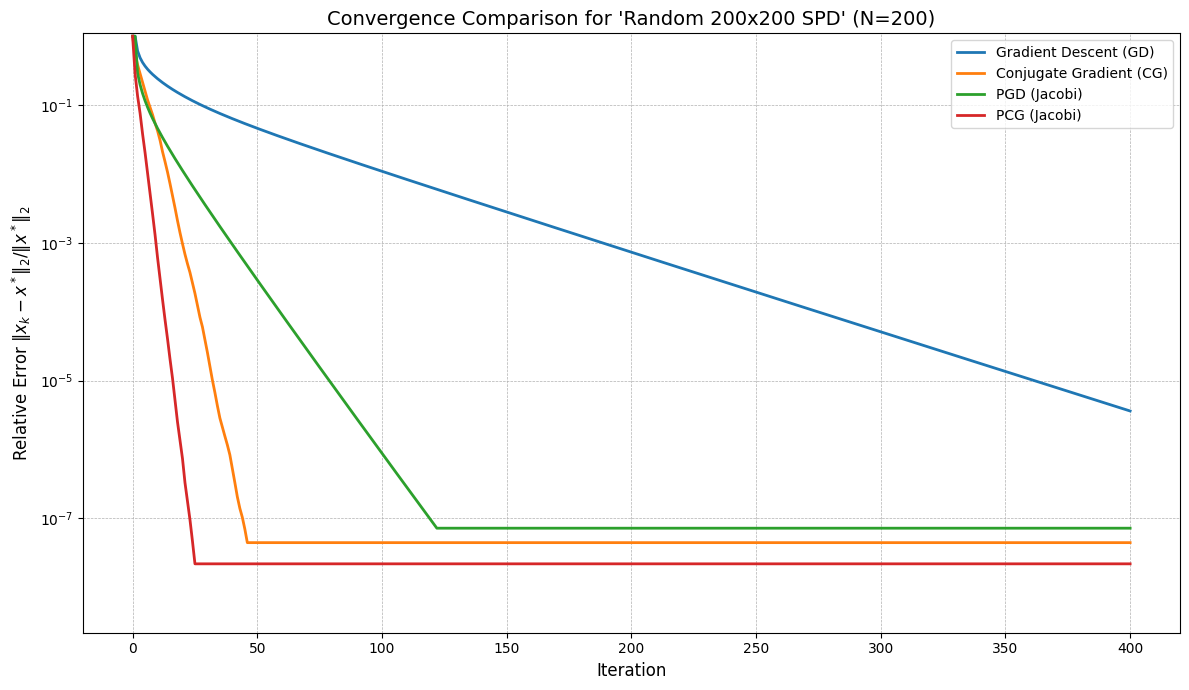


--- Exercise Completed ---


In [3]:
# exercise_pcg.py
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.io as sio
import matplotlib.pyplot as plt
import requests
import io
import tarfile
import os

def download_and_load_matrix(matrix_name="bcsstk17", data_dir="."):
    """
    Downloads and loads a matrix from the SuiteSparse Matrix Collection.
    Falls back to a random SPD matrix if download fails.
    """
    mm_filename = os.path.join(data_dir, f"{matrix_name}.mtx")
    
    if not os.path.exists(mm_filename):
        print(f"Matrix file {mm_filename} not found. Attempting download...")
        url = f"https://sparse.tamu.edu/MM/Boeing/{matrix_name}.tar.gz"
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() # Raise an exception for bad status codes
            
            # Use BytesIO to handle the tarfile in memory
            tar_data = io.BytesIO(response.content)
            
            with tarfile.open(fileobj=tar_data, mode="r:gz") as tar:
                # Find the .mtx file in the tar archive
                mtx_member_name = None
                for member in tar.getmembers():
                    if member.name.endswith(".mtx"):
                        mtx_member_name = member.name
                        break
                
                if mtx_member_name:
                    # Extract directly to the data_dir
                    member_path = os.path.join(data_dir, os.path.basename(mtx_member_name))
                    # Ensure extraction doesn't overwrite outside data_dir (security)
                    if os.path.commonpath([data_dir, os.path.abspath(member_path)]) != os.path.abspath(data_dir):
                         raise Exception("Attempted path traversal in tar file.")

                    os.makedirs(data_dir, exist_ok=True)
                    
                    # Extract the specific member
                    extracted_file = tar.extractfile(mtx_member_name)
                    if extracted_file:
                         with open(mm_filename, "wb") as f:
                              f.write(extracted_file.read())
                         print(f"Successfully downloaded and extracted {mtx_member_name} to {mm_filename}")
                    else:
                         raise Exception(f"Could not extract {mtx_member_name} from tar archive.")
                else:
                    raise FileNotFoundError("No .mtx file found in the downloaded archive.")

        except requests.exceptions.RequestException as e:
            print(f"Download failed: {e}")
            return None, None, None, False # Indicate failure
        except tarfile.TarError as e:
             print(f"Tar extraction failed: {e}")
             return None, None, None, False # Indicate failure
        except Exception as e:
             print(f"An error occurred during download/extraction: {e}")
             return None, None, None, False # Indicate failure

    # Load the matrix
    try:
        A = sio.mmread(mm_filename)
        if sp.isspmatrix_coo(A):
            A = A.tocsr() # Convert to CSR for efficient matrix-vector products
        print(f"Loaded matrix {matrix_name}: shape={A.shape}, nnz={A.nnz}")

        # Check if symmetric (required for eigsh and CG theory)
        if not np.allclose((A - A.T).data, 0):
             print("Warning: Matrix is not symmetric. Making it symmetric (A+A.T)/2.")
             A = 0.5 * (A + A.T)
             A = A.tocsr()


        # Check if positive definite by trying Cholesky or checking eigenvalues
        try:
            # Attempt Cholesky factorization (requires scikit-sparse or similar)
            # Alternatively, check smallest eigenvalue (can be slow for large matrices)
            lambda_min = spla.eigsh(A, k=1, which='SM', return_eigenvectors=False)[0]
            if lambda_min <= 1e-10: # Check if sufficiently positive
                print(f"Warning: Matrix may not be positive definite (smallest eigenvalue ~ {lambda_min}). Adding diagonal shift.")
                A = A + sp.identity(A.shape[0]) * 1e-6
            else:
                print(f"Matrix appears positive definite (smallest eigenvalue ~ {lambda_min}).")
        except Exception as e:
            print(f"Could not verify positive definiteness ({e}). Proceeding with caution.")


        # Generate true solution and rhs
        n = A.shape[0]
        np.random.seed(0)
        x_true = np.random.rand(n)
        b = A @ x_true
        return A, b, x_true, True # Indicate success

    except FileNotFoundError:
        print(f"Matrix file {mm_filename} not found after download attempt.")
        return None, None, None, False
    except Exception as e:
        print(f"Error loading matrix {mm_filename}: {e}")
        return None, None, None, False


def gradient_descent(A, b, x0, max_iter=1000, tol=1e-6, x_true=None):
    """ Solves Ax=b using Gradient Descent. """
    history = []
    x = x0.copy()
    n = A.shape[0]

    # Estimate lambda_max(A) for step size
    try:
       # Ensure A is symmetric before calling eigsh
       if not hasattr(A, 'symmetric') or not A.symmetric:
           if np.allclose((A - A.T).data, 0):
               A.symmetric = True # Mark as symmetric if it is
           else: # If not symmetric, eigsh on non-symmetric matrices is deprecated/problematic
               raise ValueError("Matrix A must be symmetric for eigsh.")
       lambda_max = spla.eigsh(A, k=1, which='LM', return_eigenvectors=False)[0]
       # Optimal step size for quadratic requires lambda_min as well
       # lambda_min = spla.eigsh(A, k=1, which='SM', return_eigenvectors=False)[0]
       # tau = 2.0 / (lambda_max + lambda_min)
       # Simpler choice (may converge slower):
       tau = 1.0 / lambda_max
    except Exception as e:
       print(f"Warning: eigsh failed for A ({e}), using fixed step size 1e-7 for GD")
       tau = 1e-7 # Small fixed fallback

    print(f"Using step size tau = {tau:.2e} for GD")

    norm_xtrue = np.linalg.norm(x_true) if x_true is not None else 1.0
    norm_b = np.linalg.norm(b)

    if x_true is not None:
        history.append(np.linalg.norm(x0 - x_true) / norm_xtrue)
    else:
        history.append(np.linalg.norm(b - A @ x0) / norm_b)

    for k in range(max_iter):
        r = b - A @ x
        norm_r = np.linalg.norm(r)

        if x_true is not None:
            err = np.linalg.norm(x - x_true) / norm_xtrue
            history.append(err)
        else:
            # Use relative residual
            history.append(norm_r / norm_b)

        # Use relative tolerance for residual check
        if norm_r / norm_b < tol:
            print(f"GD converged in {k} iterations.")
            break

        x = x + tau * r
    else: # Loop finished without break
        print(f"GD did not converge within {max_iter} iterations.")


    # Pad history if converges early
    actual_iters = len(history)
    if actual_iters < max_iter + 1:
       history.extend([history[-1]] * (max_iter + 1 - actual_iters))

    return x, history[:max_iter+1]

def conjugate_gradient_scipy(A, b, x0, max_iter=1000, tol=1e-6, x_true=None):
    """ Solves Ax=b using scipy's Conjugate Gradient. """
    history = []
    norm_xtrue = np.linalg.norm(x_true) if x_true is not None else 1.0
    norm_b = np.linalg.norm(b)

    if x_true is not None:
        history.append(np.linalg.norm(x0 - x_true) / norm_xtrue)
    else:
        history.append(np.linalg.norm(b - A @ x0) / norm_b)

    iter_count = 0
    def callback(xk):
        nonlocal iter_count
        iter_count += 1
        if x_true is not None:
             err = np.linalg.norm(xk - x_true) / norm_xtrue
             history.append(err)
        else:
             # Use relative residual
             r = b - A @ xk
             norm_r = np.linalg.norm(r)
             history.append(norm_r / norm_b)

    # Use relative tolerance for spla.cg
    x, info = spla.cg(A, b, x0=x0, maxiter=max_iter, tol=tol, callback=callback)

    if info == 0:
        print(f"CG converged in {iter_count} iterations.")
    elif info > 0:
        print(f"CG did not converge within {info} iterations.")
    else:
        print(f"CG failed with error code {info}.")


    # Pad history if converges early
    actual_iters = len(history)
    if actual_iters < max_iter + 1:
       history.extend([history[-1]] * (max_iter + 1 - actual_iters))

    return x, history[:max_iter+1] # Return history up to max_iter

def jacobi_preconditioner(A):
   
    return P_inv

# ============================================================
# === EXERCISE: Implement Preconditioned Methods ===
# ============================================================
# Objective: Implement PGD and PCG using the Jacobi preconditioner.
# The functions below are provided as a solution.
# For the exercise, you might comment out the implementation details
# and try to write them yourself based on the GD/CG implementations
# and the lecture notes on preconditioning.

def preconditioned_gradient_descent(A, b, x0, P_inv, max_iter=1000, tol=1e-6, x_true=None):
    """
    Solves Ax=b using Preconditioned Gradient Descent with a given preconditioner P_inv.
    P_inv should be a LinearOperator for the inverse of the preconditioner matrix P.
    """
    history = []
    x = x0.copy()
    n = A.shape[0]

    # Estimate lambda_max(P_inv * A) for step size
    # Note: P_inv * A is generally not symmetric even if A and P are.
    # eigsh requires symmetric operators. Power iteration is safer for lambda_max.
    # For simplicity here, we'll try eigsh assuming effective symmetry or use fallback.
    tau = 1e-7 # Small fixed fallback step size

    try:
        # Define the operator P_inv * A
        # Note: For Jacobi (P=diag(A)), if A is SPD, P is SPD, and P^{-1/2} A P^{-1/2} is SPD.
        # We apply GD to the transformed system P^{-1}Ax = P^{-1}b, or minimize
        # f(x) w.r.t. P-inner product. Update is x = x + tau * P^{-1}r
        # Step size depends on eigenvalues of P^{-1}A
        P_inv_A_op = spla.LinearOperator(A.shape, matvec=lambda v: P_inv @ (A @ v))
        # Use power iteration (or eigsh if confident about symmetry properties)
        # spla.eigsh might fail if P_inv_A is not symmetric.
        # Power iteration finds the largest eigenvalue in magnitude.
        # We need largest positive eigenvalue for step size calculation if P_inv A is SPD.
        # If A is SPD and P=diag(A) with positive entries, P_inv*A is similar to P^{-1/2}AP^{-1/2} which is SPD.
        lambda_max_prec = spla.eigsh(P_inv_A_op, k=1, which='LM', return_eigenvectors=False, tol=1e-3)[0]

        # Heuristic step size (often too conservative or requires lambda_min too)
        if lambda_max_prec > 1e-10:
             tau = 1.0 / lambda_max_prec
        else:
            print("Warning: Estimated lambda_max(P_inv*A) is close to zero.")
            # tau remains the fallback
    except Exception as e:
        print(f"Warning: eigsh failed for P_inv_A ({e}), using fixed step size {tau:.1e} for PGD")
        # tau remains the fallback

    print(f"Using step size tau = {tau:.2e} for PGD")

    norm_xtrue = np.linalg.norm(x_true) if x_true is not None else 1.0
    norm_b = np.linalg.norm(b)

    if x_true is not None:
        history.append(np.linalg.norm(x0 - x_true) / norm_xtrue)
    else:
        history.append(np.linalg.norm(b - A @ x0) / norm_b)

    for k in range(max_iter):
        r = b - A @ x
        norm_r = np.linalg.norm(r)

        if x_true is not None:
            err = np.linalg.norm(x - x_true) / norm_xtrue
            history.append(err)
        else:
            # Use relative residual
            history.append(norm_r / norm_b)

        # Use relative tolerance for residual check
        if norm_r / norm_b < tol:
            print(f"PGD converged in {k} iterations.")
            break

        z = P_inv @ r # Apply preconditioner: z_k = P^{-1} r_k
        x = x + tau * z # Update using preconditioned residual: x_{k+1} = x_k + tau * z_k

    else: # Loop finished without break
        print(f"PGD did not converge within {max_iter} iterations.")

    # Pad history if converges early
    actual_iters = len(history)
    if actual_iters < max_iter + 1:
       history.extend([history[-1]] * (max_iter + 1 - actual_iters))

    return x, history[:max_iter+1]


def preconditioned_conjugate_gradient_scipy(A, b, x0, P_inv, max_iter=1000, tol=1e-6, x_true=None):
    """
    Solves Ax=b using Preconditioned Conjugate Gradient with scipy's cg.
    P_inv should be a LinearOperator for the inverse of the preconditioner P.
    """
    history = []
    norm_xtrue = np.linalg.norm(x_true) if x_true is not None else 1.0
    norm_b = np.linalg.norm(b)

    if x_true is not None:
        history.append(np.linalg.norm(x0 - x_true) / norm_xtrue)
    else:
        history.append(np.linalg.norm(b - A @ x0) / norm_b)

    iter_count = 0
    def callback(xk):
        nonlocal iter_count
        iter_count += 1
        if x_true is not None:
            err = np.linalg.norm(xk - x_true) / norm_xtrue
            history.append(err)
        else:
            # Use relative residual
            r = b - A @ xk
            norm_r = np.linalg.norm(r)
            history.append(norm_r / norm_b)

    # Use spla.cg with the M argument for the preconditioner (M = P_inv)
    # M must represent the action of P_inv.
    x, info = spla.cg(A, b, x0=x0, maxiter=max_iter, tol=tol, M=P_inv, callback=callback)

    if info == 0:
        print(f"PCG converged in {iter_count} iterations.")
    elif info > 0:
        print(f"PCG did not converge within {info} iterations.")
    else:
        print(f"PCG failed with error code {info}.")

    # Pad history if converges early
    actual_iters = len(history)
    if actual_iters < max_iter + 1:
       history.extend([history[-1]] * (max_iter + 1 - actual_iters))

    return x, history[:max_iter+1]

# ============================================================
# === END OF EXERCISE SECTION ===
# ============================================================

def plot_convergence(histories, labels, title="Convergence Comparison", use_error=True):
    """ Plots the convergence history of multiple methods. """
    plt.figure(figsize=(12, 7))
    for history, label in zip(histories, labels):
        if history: # Check if history exists (method might have been skipped)
             # Ensure history length matches iterations 0 to max_iter
             iterations = range(len(history))
             plt.semilogy(iterations, history, label=label, linewidth=2)

    plt.xlabel("Iteration", fontsize=12)
    ylabel = "Relative Error $\|x_k - x^*\|_2 / \|x^*\|_2$" if use_error else "Relative Residual Norm $\|Ax_k - b\|_2 / \|b\|_2$"
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # Adjust ylim based on expected convergence, avoid overly small limits if methods don't converge well
    min_val = min(h[-1] for h in histories if h)
    plt.ylim(bottom=max(1e-12, min_val / 10), top=1.1 * max(h[0] for h in histories if h)) # Start slightly above initial error/residual
    plt.tight_layout()
    plt.show()

# Main execution block
if __name__ == "__main__":
    MATRIX_NAME = "bcsstk17"
    DATA_DIR = "./matrix_data" # Directory to store downloaded matrix

    # Download or generate matrix
    A, b, x_true, loaded_real_matrix = download_and_load_matrix(MATRIX_NAME, DATA_DIR)

    if not loaded_real_matrix:
        print("Falling back to a random SPD matrix.")
        # Generate a small random SPD matrix as fallback
        n = 200 # Larger random matrix
        np.random.seed(0)
        # Generate sparse matrix directly
        density = 0.01
        A = sp.random(n, n, density=density, format='csr', random_state=0)
        A = 0.5 * (A + A.T) # Make symmetric
        # Ensure positive definiteness by adding diagonal dominance
        diag_shift = sp.diags(A.sum(axis=1).A1 + 0.1, 0, format='csr')
        A = A + diag_shift
        
        x_true = np.random.rand(n)
        b = A @ x_true
        MATRIX_NAME = f"Random {n}x{n} SPD"
        print(f"Using random matrix: shape={A.shape}, nnz={A.nnz}")
        
    use_error_metric = (x_true is not None)
    n_dim = A.shape[0]
    x0 = np.zeros(n_dim) # Initial guess

    # Parameters
    MAX_ITER = min(1000, 2 * n_dim) # Max iterations, capped
    TOL = 1e-8 # Relative tolerance

    # --- Run Methods ---
    print("\n--- Running Solvers ---")
    x_gd, hist_gd = gradient_descent(A, b, x0, max_iter=MAX_ITER, tol=TOL, x_true=x_true)
    x_cg, hist_cg = conjugate_gradient_scipy(A, b, x0, max_iter=MAX_ITER, tol=TOL, x_true=x_true)

    # Setup and run preconditioned methods
    hist_pgd, hist_pcg = None, None
    try:
        print("\nSetting up Jacobi Preconditioner...")
        P_inv = jacobi_preconditioner(A)
        print("Running Preconditioned Gradient Descent (PGD)...")
        x_pgd, hist_pgd = preconditioned_gradient_descent(A, b, x0, P_inv, max_iter=MAX_ITER, tol=TOL, x_true=x_true)
        print("Running Preconditioned Conjugate Gradient (PCG)...")
        x_pcg, hist_pcg = preconditioned_conjugate_gradient_scipy(A, b, x0, P_inv, max_iter=MAX_ITER, tol=TOL, x_true=x_true)
    except ValueError as e:
        print(f"\nError setting up/using Jacobi preconditioner: {e}")
        print("Skipping preconditioned methods.")
        P_inv = None

    # --- Plot Results ---
    print("\n--- Plotting Convergence ---")
    histories_list = [hist_gd, hist_cg]
    labels_list = ["Gradient Descent (GD)", "Conjugate Gradient (CG)"]
    if hist_pgd:
        histories_list.append(hist_pgd)
        labels_list.append("PGD (Jacobi)")
    if hist_pcg:
        histories_list.append(hist_pcg)
        labels_list.append("PCG (Jacobi)")

    plot_title = f"Convergence Comparison for '{MATRIX_NAME}' (N={n_dim})"
    plot_convergence(histories_list, labels_list, title=plot_title, use_error=use_error_metric)

    print("\n--- Exercise Completed ---")
